

# LASSO-, Ridge-, ElasticNet-регрессии и их оптимизация

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

##### Реализованные классы с прошлого семинара:


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
def linear_expression(x):
    return 5 * x + 6

In [ ]:
objects_num = 50
X = np.linspace(-5, 5, objects_num)
y = linear_expression(X) + np.random.randn(objects_num) * 5

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)

In [ ]:
class MyLinearRegression:
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept

    def fit(self, X, y):
        # Принимает на вход X, y и вычисляет веса по данной выборке
        # Не забудьте про фиктивный признак равный 1

        n, k = X.shape

        X_train = X
        if self.fit_intercept:
            X_train = np.hstack((X, np.ones((n, 1))))

        self.w = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y

        return self

    def predict(self, X):
        # Принимает на вход X и возвращает ответы модели
        # Не забудьте про фиктивный признак равный 1
        n, k = X.shape
        if self.fit_intercept:
            X_train = np.hstack((X, np.ones((n, 1))))

        y_pred = X_train @ self.w

        return y_pred

    def get_weights(self):
        return self.w

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
class MyGradientLinearRegression(MyLinearRegression):
    def __init__(self, **kwargs):
        super().__init__(**kwargs) # передает именные параметры родительскому конструктору
        self.w = None

    def fit(self, X, y, lr=0.01, max_iter=100):
        # Принимает на вход X, y и вычисляет веса по данной выборке
        # Не забудьте про фиктивный признак равный 1!

        n, k = X.shape

        # случайно инициализируем веса
        if self.w is None:
            self.w = np.random.randn(k + 1 if self.fit_intercept else k)

        X_train = np.hstack((X, np.ones((n, 1)))) if self.fit_intercept else X

        self.losses = []

        for iter_num in range(max_iter):
            y_pred = self.predict(X)
            self.losses.append(mean_squared_error(y_pred, y))

            grad = self._calc_gradient(X_train, y, y_pred)

            assert grad.shape == self.w.shape, f"gradient shape {grad.shape} is not equal weight shape {self.w.shape}"
            self.w -= lr * grad

        return self

    def _calc_gradient(self, X, y, y_pred):
        grad = 2 * (y_pred - y)[:, np.newaxis] * X
        grad = grad.mean(axis=0)
        return grad

    def get_losses(self):
        return self.losses

In [ ]:
class MySGDLinearRegression(MyGradientLinearRegression):
    def __init__(self, n_sample=10, **kwargs):
        super().__init__(**kwargs) # передает именные параметры родительскому конструктору
        self.w = None
        self.n_sample = n_sample

    def _calc_gradient(self, X, y, y_pred):
        # Главное отличие в SGD -- это использование подвыборки для шага оптимизации
        inds = np.random.choice(np.arange(X.shape[0]), size=self.n_sample, replace=False)

        grad = 2 * (y_pred[inds] - y[inds])[:, np.newaxis] * X[inds]
        grad = grad.mean(axis=0)

        return grad

# 1. О регуляризации

Обычно модели обучаются на каких-то зашумленных данных. Веса моделей после обучения подбираются для уменьшения ошибки целевой функции. **На различных выборках модель может обучаться по-разному, но нам бы хотелось вычленять основную зависимость примерно одинаково**, то есть **не переобучаться (overfit)** на данных. Иначе обучившись на одном сете, мы можем получать неожиданный и очень неприятный результат на других данных.

То есть мы хотели бы штрафовать модель за поиск слишком сложных связей, чтобы выискивать более простые зависимости.


Еще одной проблемой, специфичной для линейных моделей, является **мультиколлинеарность**. Особенность мультиколлинеарности заключается в том, что из-за того, что решений становится бесконечно много, веса модели могут принимать очень большие значения, при этом модель может быть также чувствительна к мелким изменениям признаков из-за этого, поэтому **необходимо каким-то образом ограничить величину весов модели**.

Для линейной модели дополнительные ограничения на веса выполняют роль регуляризации. Различают:
- $L_1$-регуляризацию (LASSO, least absolute shrinkage and selection operator), учитывание $||w||_1$;
- $L_2$-регуляризацию (Ridge), учитывание $||w||^2_2$;
- Elastic Net - комбинация двух предыдущих (учитываются обе нормы весов).

# 2. Ridge-регрессия ($L_2$-регуляризация, регуляризация Тихонова)

В Ridge мы штрафуем модель также на сумму квадратов всех ее весов, таким образом:

**Лосс:** $L(w) = ||Xw - Y||^2_2 + \alpha||w||^2_2$, где $\alpha$ - **гиперпараметр** (что это?), отвечающий за степень регуляризации.

В привычном понимании:

**Лосс:** $L(w) = \sum_{i=1}^n\left(\sum_{j=1}^{m} x_{ij}w_j - y_i\right)^2 + \alpha\sum_{j=1}^{m}w_j^2$

Что стоит сказать про значения признаков? Они должны быть стандартизованы для одинаковых штрафов относительно друг друга! (используется связка с `sklearn.preprocessing.StandardScaler`)

In [ ]:
from sklearn.linear_model import Ridge

In [ ]:
reg = Ridge(alpha=1/3).fit(X[:, np.newaxis], y)
np.append(reg.coef_, reg.intercept_)

array([5.24204553, 6.11446782])

### 2.1. Аналитическое решение

Из курса статистики нам (не)известно, что если:
$$ L(w) = ||Xw - Y||^2_2 + ||\Gamma w||^2_2 $$

минимизируется при:

$$ w = (X^TX + \Gamma^T \Gamma)^{-1}X^TY, $$

где $Γ$ - матрица регуляризации - диагональная матрица, элементы которой определяют силу регуляризации для каждого из коэффициентов модели.

В нашем случае $\Gamma^T\Gamma = \alpha E$, если нет свободного члена, иначе:
$\Gamma^T\Gamma =
\left(\begin{matrix}
\alpha E & 0 \\
0 & 0
\end{matrix}\right)$, т.е. (важно!) свободный член не включается в регуляризацию, большой $b$ не чувствителен к мелким изменениям других признаков.

**Как вы думаете, гарантируется ли нахождение обратной матрицы в таком случае?**


In [ ]:
class MyRidgeRegression(MyLinearRegression):
    def __init__(self, alpha=1.0, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha

    def fit(self, X, y):
        n, m = X.shape
        X_train = X

        if self.fit_intercept:
            X_train = np.hstack((X, np.ones((n, 1))))

        lambdaE = self.alpha * np.eye(X_train.shape[1])
        if self.fit_intercept:
            lambdaE[-1, -1] = 0

        self.w = np.linalg.inv(X_train.T @ X_train + lambdaE) @ X_train.T @ y

        return self

    def get_weights(self):
        return self.w

Протестируем решение на датасете:

In [ ]:
alpha = 1.0
regressor = MyRidgeRegression(alpha=alpha).fit(X_train[:, np.newaxis], y_train)

Проверим работу, сравнив с `linear_model.Ridge` из sklearn

In [ ]:
sklearn_reg = Ridge(alpha).fit(X_train[:, np.newaxis], y_train)
assert np.allclose(regressor.get_weights(), np.append(sklearn_reg.coef_, sklearn_reg.intercept_))
regressor.get_weights()

array([5.31523562, 5.69472495])

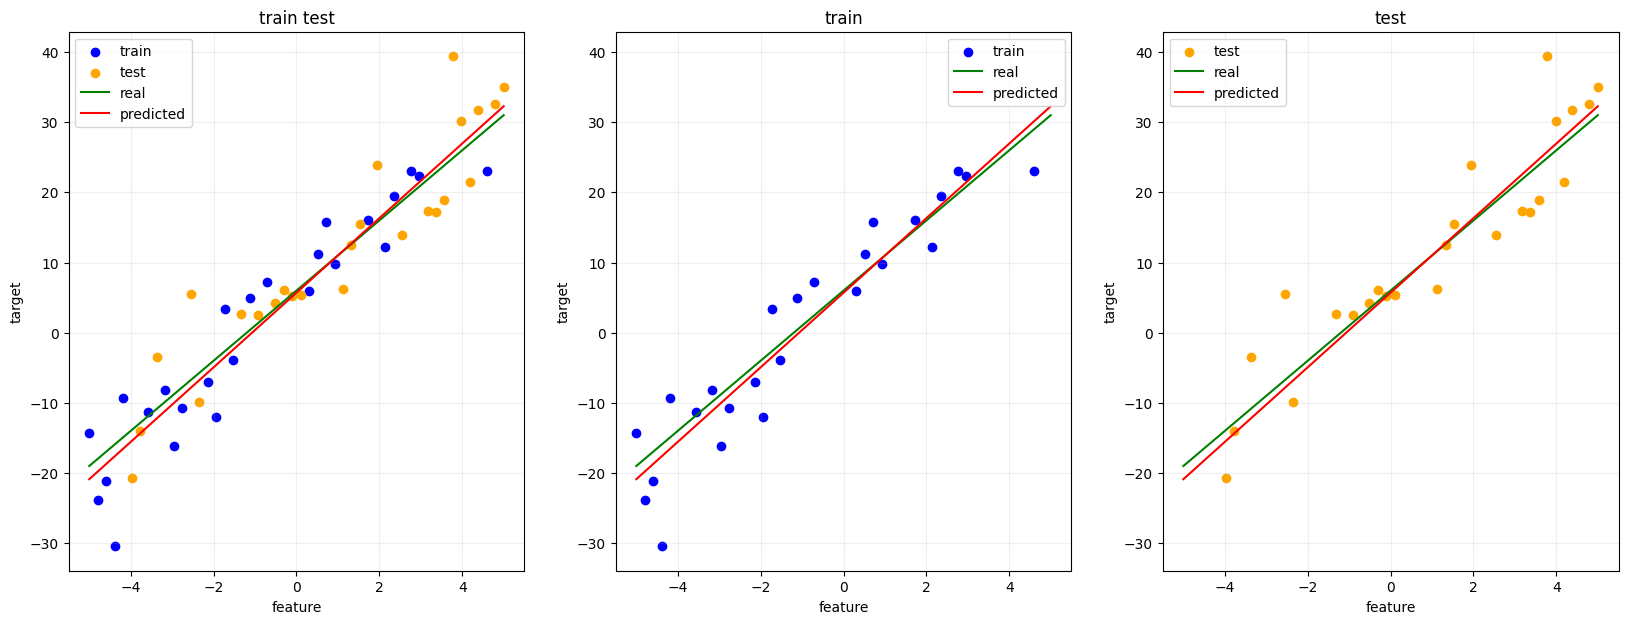

In [ ]:
plt.figure(figsize=(20, 7))

ax = None

for i, types in enumerate([['train', 'test'], ['train'], ['test']]):
    ax = plt.subplot(1, 3, i + 1, sharey=ax)
    if 'train' in types:
        plt.scatter(X_train, y_train, label='train', c='b')
    if 'test' in types:
        plt.scatter(X_test, y_test, label='test', c='orange')

    plt.plot(X, linear_expression(X), label='real', c='g')
    plt.plot(X, regressor.predict(X[:, np.newaxis]), label='predicted', c='r')

    plt.ylabel('target')
    plt.xlabel('feature')
    plt.title(" ".join(types))
    plt.grid(alpha=0.2)
    plt.legend()

plt.show()

### 2.2 SGD

Аналогично предыдущим заданиям нужно рассчитать значение градиента $\displaystyle\frac{\partial{L}}{\partial{w}}$

**Имеем:**
$$
\begin{aligned}L(w) &= ||Xw - Y||^2_2 + ||\Gamma w||^2_2
= (Xw - Y)^T(Xw - Y) + w^T\Gamma^T\Gamma w = \\
&= w^TX^TXw - 2Y^TXw + Y^TY + w^T\Gamma^T\Gamma w =
w^T(X^TX + \Gamma^T\Gamma)w - 2Y^TXw + Y^TY
\end{aligned}
$$

**Градиент:**
$$
\frac{\partial{L}}{\partial{w}}
= 2(X^TX + \Gamma^T\Gamma)w - 2X^TY
$$

Будем также усреднять значения лосса по батчу данных: появится множитель $\displaystyle\frac{1}{n_{sample}}$

Реализуем наш класс Ridge регрессии используя стохастический градиентный спуск


In [ ]:
class MySGDRidge(MySGDLinearRegression):
    def __init__(self, alpha=1.0, **kwargs):
        super().__init__(**kwargs) # передает именные параметры родительскому конструктору
        self.w = None
        self.alpha = alpha

    def _calc_gradient(self, X, y, y_pred):
        # Главное отличие в SGD - это использование подвыборки для шага оптимизации
        inds = np.random.choice(np.arange(X.shape[0]), size=self.n_sample, replace=False)

        lambdaE = self.alpha * np.eye(self.w.shape[0])
        if self.fit_intercept:
            lambdaE[-1, -1] = 0

        grad = 2 * (X[inds].T @ X[inds] / self.n_sample + lambdaE) @ self.w
        grad -= 2 * X[inds].T @ y[inds] / self.n_sample

        return grad

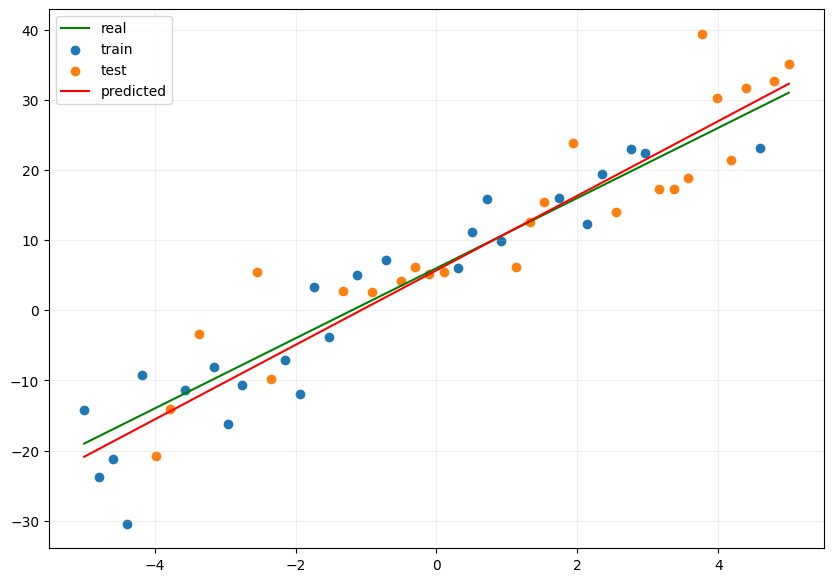

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(X, linear_expression(X), label='real', c='g')

plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.plot(X, regressor.predict(X[:, np.newaxis]), label='predicted', c='r')

plt.grid(alpha=0.2)
plt.legend()
plt.show()

In [ ]:
regressor = MySGDRidge(alpha=1, n_sample=20).fit(X[:, np.newaxis], y, max_iter=1000, lr=0.01)
l = regressor.get_losses()
regressor.get_weights()

array([4.63198678, 6.12669022])

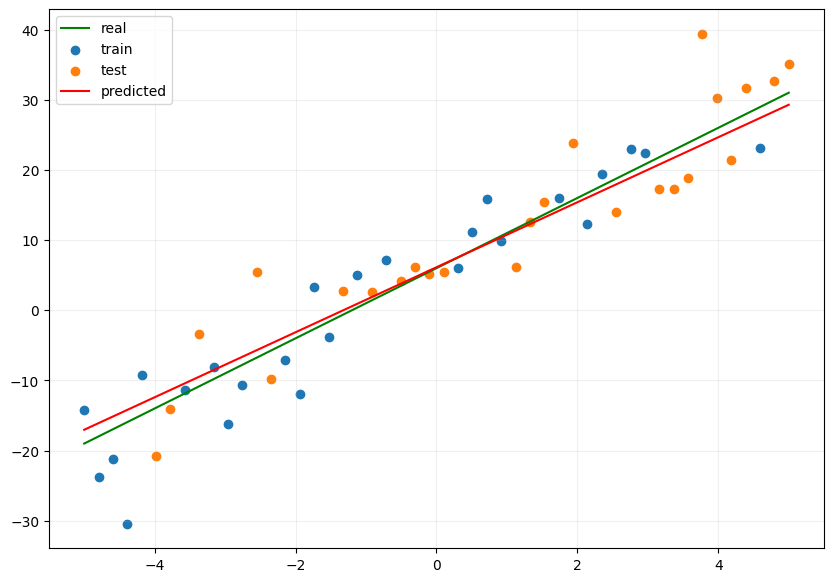

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(X, linear_expression(X), label='real', c='g')

plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.plot(X, regressor.predict(X[:, np.newaxis]), label='predicted', c='r')

plt.grid(alpha=0.2)
plt.legend()
plt.show()

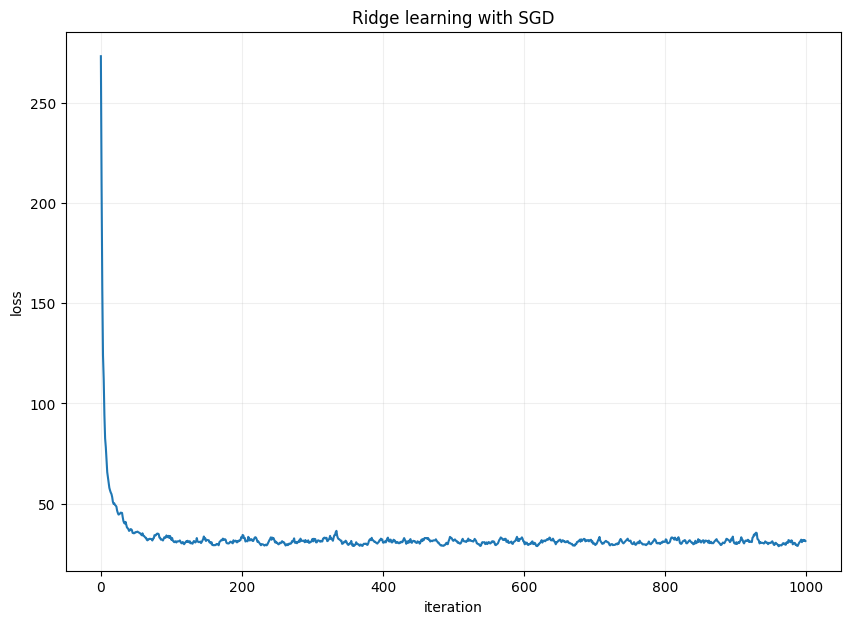

In [ ]:
plt.figure(figsize=(10, 7))

plt.plot(l)

plt.title('Ridge learning with SGD')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.grid(alpha=0.2)
plt.show()

# 3. LASSO-регрессия ($L_1$-регуляризация)

В LASSO мы штрафуем модель также **на сумму модулей всех ее весов** (на $L_1$-норму весов), таким образом:

**Лосс:** $L(w) = \frac{1}{2n} ||Xw - Y||^2_2 + \alpha ||w||_1$, где $\alpha$ - гиперпараметр, отвечающий за степень регуляризации.

В привычном понимании:

**Лосс:** $L(w) = \frac{1}{2n}\sum_{i=1}^n\left(\sum_{j=1}^{m} x_{ij}w_j - y_i\right)^2 + \alpha\sum_{j=1}^{m}|w_j|$

Признаки опять же должны быть стандартизованы для одинаковых штрафов относительно друг друга!

In [ ]:
from sklearn.linear_model import Lasso

In [ ]:
reg = Lasso(alpha=1).fit(X[:, np.newaxis], y)
np.append(reg.coef_, reg.intercept_)

array([5.13078059, 6.11446782])

### 3.1 Аналитическое решение

В отличие от Ridge, аналитическое решение задачи Lasso-регрессии в общем случае не находится (как думаете, почему?)

In [ ]:
# No analytic solution!

### 3.2 SGD

Аналогично предыдущим заданиям для SGD нужно рассчитать значение градиента $\displaystyle\frac{\partial{L}}{\partial{w}}$

**Лосс:**
$$
\begin{aligned}L(w) &= \frac{1}{2n}||Xw - Y||^2_2 + ||\Gamma w||_1
= \frac{1}{2n}(Xw - Y)^T(Xw - Y) + ||\Gamma w||_1 = \\
&= \frac{1}{2n}(w^TX^TXw - 2Y^TXw + Y^TY) + \lambda\sum_{i=1}^{m-1}|w|
\end{aligned}
$$

**Градиент:**
$$
\frac{\partial{L}}{\partial{w}}
= \frac{1}{n}(X^TXw - X^TY) + \lambda sign(w)
= \frac{1}{n}X^T(y_{pred} - Y) + \lambda sign(w)
$$

где для приближения будем считать что $|\cdot|$ - дифференцируемая функция, ее производной является $sign(\cdot)$. **(по-хорошему, это уже не градиентный спуск, а субградиентный, так как оптимизирует изначально недифференцируемую функцию)**

Реализуем наш класс Lasso регрессии, используя стохастический градиентный спуск


In [ ]:
def soft_sign(x, eps=1e-7):
    if abs(x) > eps:
        return np.sign(x)
    return x / eps

np_soft_sign = np.vectorize(soft_sign)

class MySGDLasso(MySGDLinearRegression):
    def __init__(self, alpha=1.0, **kwargs):
        super().__init__(**kwargs) # передает именные параметры родительскому конструктору
        self.w = None
        self.alpha = alpha

    def _calc_gradient(self, X, y, y_pred):
        # Главное отличие в SGD - это использование подвыборки для шага оптимизации
        inds = np.random.choice(np.arange(X.shape[0]), size=self.n_sample, replace=False)

        signw = np_soft_sign(self.w)
        if self.fit_intercept:
            signw[-1] = 0

        grad = X[inds].T @ (y_pred[inds] - y[inds])[:, np.newaxis] / self.n_sample
        grad += self.alpha * signw[:, np.newaxis]

        return grad.flatten()

Протестируем

In [ ]:
regressor = MySGDLasso(alpha=1, n_sample=4).fit(X[:, np.newaxis], y, max_iter=1000, lr=0.01)
l = regressor.get_losses()
regressor.get_weights()

array([5.18279658, 5.96392023])

In [ ]:
sklearn_reg = Lasso().fit(X[:, np.newaxis], y)
np.append(sklearn_reg.coef_, sklearn_reg.intercept_)

array([5.13078059, 6.11446782])

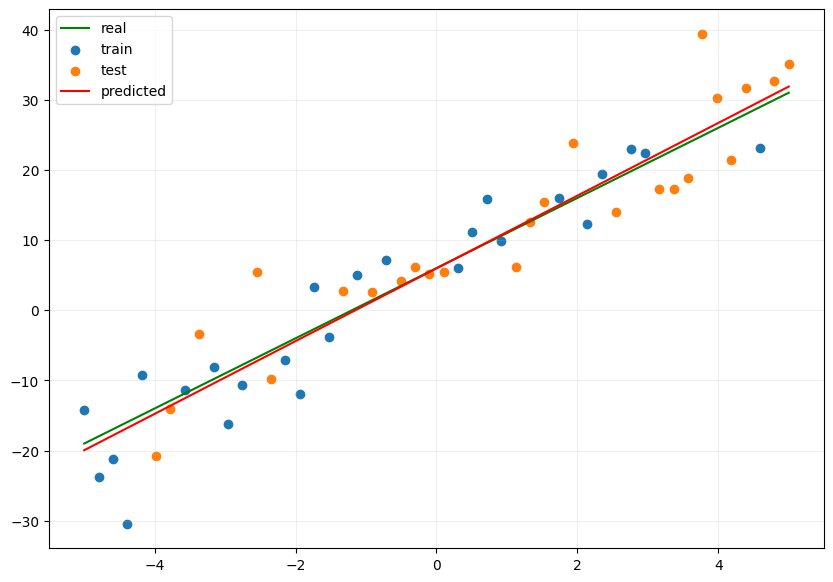

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(X, linear_expression(X), label='real', c='g')

plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.plot(X, regressor.predict(X[:, np.newaxis]), label='predicted', c='r')

plt.grid(alpha=0.2)
plt.legend()
plt.show()

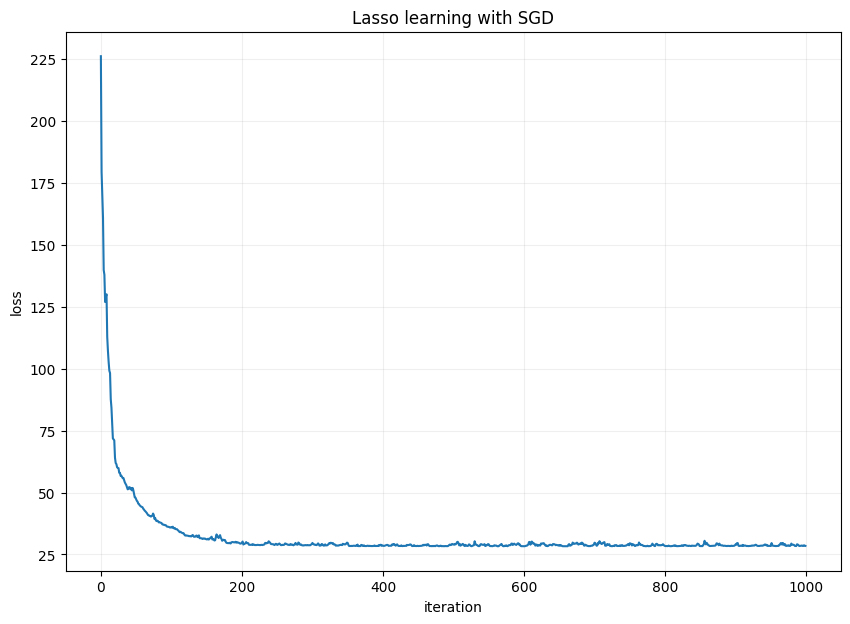

In [ ]:
plt.figure(figsize=(10, 7))

plt.plot(l)

plt.title('Lasso learning with SGD')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.grid(alpha=0.2)
plt.show()

# 4. Различия LASSO и Ridge

*Откуда эти кружочки О_о*

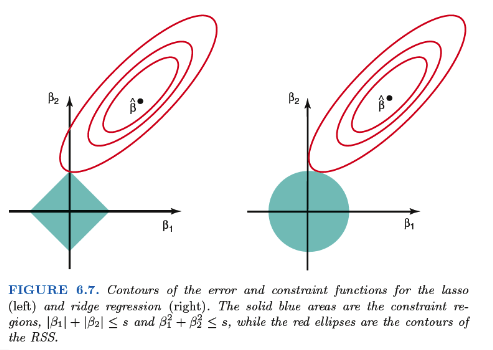

Различия $L_1$ и $L_2$ регуляризаций:

#### $L_1$ (Lasso):

* Lasso автоматически отбирает наиболее значимые признаки, зануляя веса для менее важных;
* Не имеет аналитического решения, требует итеративных методов;
* Хорошо справляется с коллинеарными признаками, но может случайно выбрать один из коррелирующих признаков.

#### $L_2$ (Ridge):

* Сжимает веса, но не зануляет их полностью, поэтому не отбирает признаки;
* Улучшает устойчивость модели к шуму и переобучению, особенно когда в данных есть коллинеарные признаки;
* Имеет аналитическое решение, что упрощает вычисления.


### $L_{0.5}$ (???) Это что, шутка?

**Не шутка**, у признаков не остаётся шансов: их почти точно занулят😈

$L_{0.5}$, $L_{1}$, $L_{2}$ соответственно

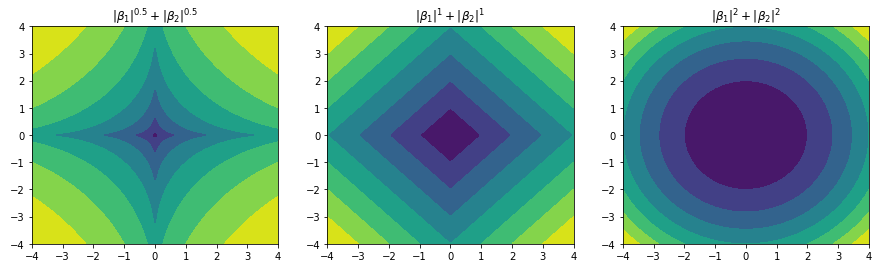

# 5. ElasticNet (L1+L2)

**Лосс:** $L(w) = \frac{1}{2n}||Xw - Y||^2_2 + \alpha r ||w||_1 + 0.5 * \alpha * (1 - r) ||w||^2_2$, где $\alpha, r = {l1\_ratio}$ - гиперпараметры, отвечающие за степень регуляризации.

* Объединяет преимущества обеих регуляризаций: отбор признаков от L1 и устойчивость от L2.
* Позволяет гибко настраивать баланс между L1 и L2 с помощью параметров alpha и l1_ratio.

In [ ]:
from sklearn.linear_model import ElasticNet

In [ ]:
reg = ElasticNet(alpha=0.5, l1_ratio=0.5).fit(X[:, np.newaxis], y)
np.append(reg.coef_, reg.intercept_)

array([5.07108462, 6.11446782])

Визуально сравним регрессии

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
reg = LinearRegression().fit(X[:, np.newaxis], y)
ereg = ElasticNet(alpha=0.5, l1_ratio=0.5).fit(X[:, np.newaxis], y)
rreg = Ridge(alpha=1).fit(X[:, np.newaxis], y)
lreg = Lasso(alpha=1).fit(X[:, np.newaxis], y)

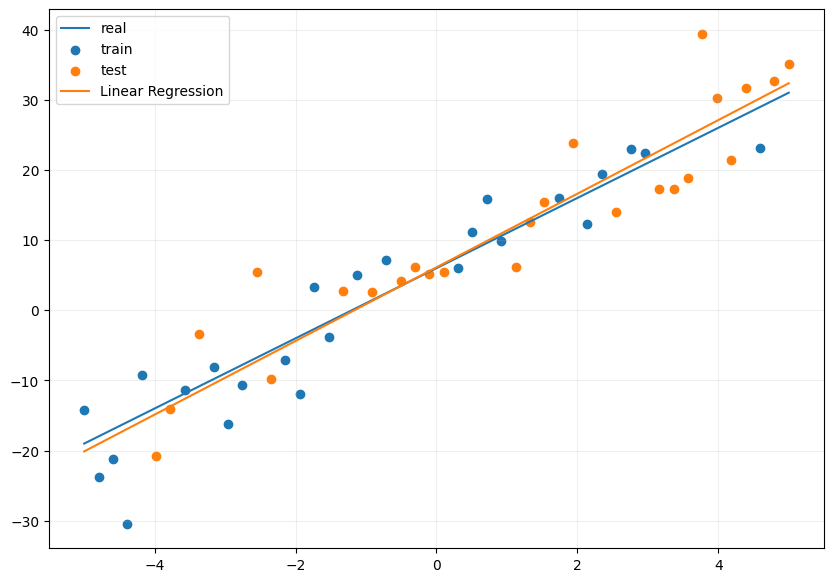

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(X, linear_expression(X), label='real')

plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.plot(X, reg.predict(X[:, np.newaxis]), label='Linear Regression')

plt.grid(alpha=0.2)
plt.legend()
plt.show()

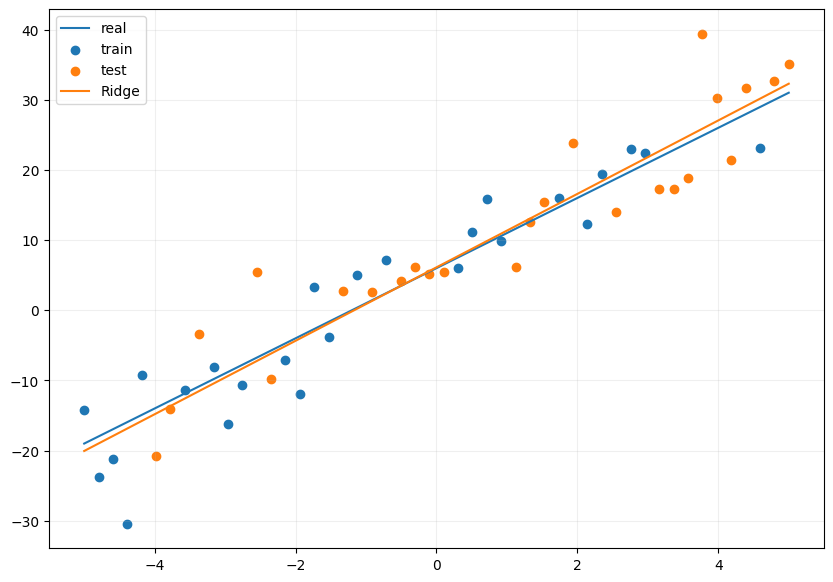

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(X, linear_expression(X), label='real')

plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.plot(X, rreg.predict(X[:, np.newaxis]), label='Ridge')

plt.grid(alpha=0.2)
plt.legend()
plt.show()

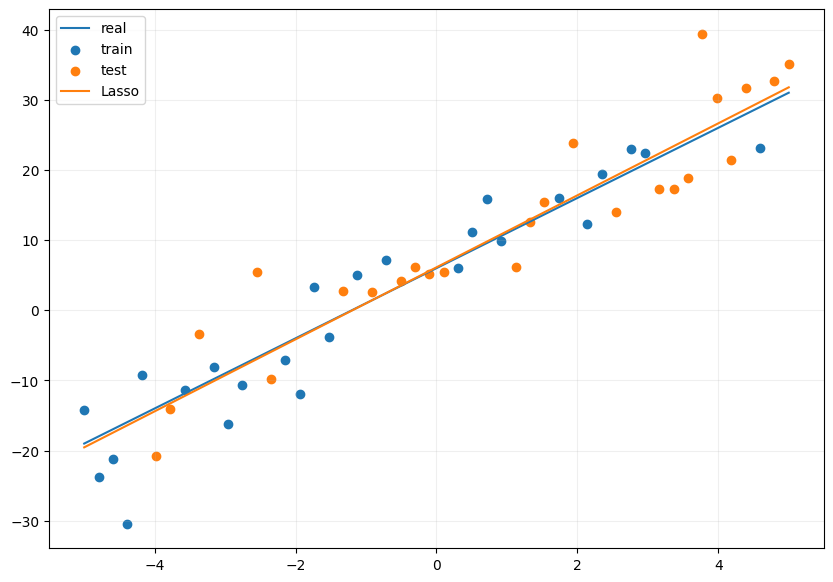

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(X, linear_expression(X), label='real')

plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.plot(X, lreg.predict(X[:, np.newaxis]), label='Lasso')

plt.grid(alpha=0.2)
plt.legend()
plt.show()

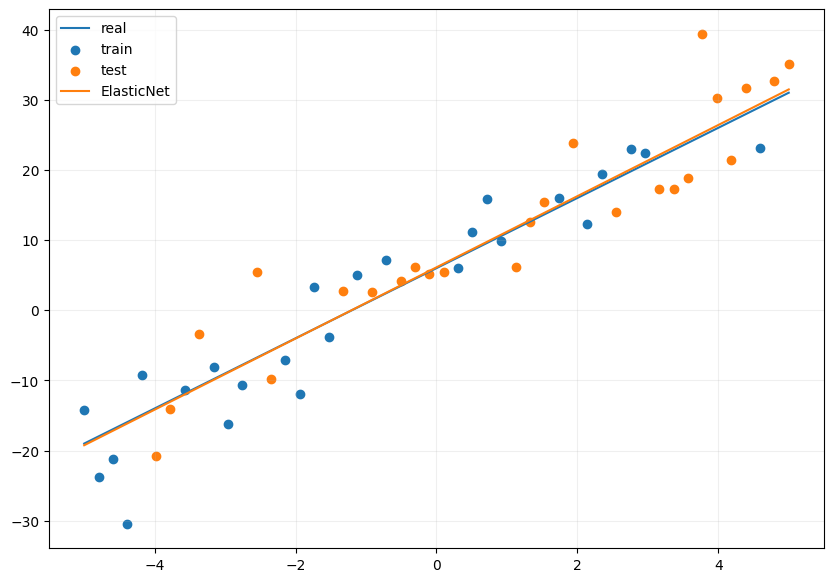

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(X, linear_expression(X), label='real')

plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.plot(X, ereg.predict(X[:, np.newaxis]), label='ElasticNet')

plt.grid(alpha=0.2)
plt.legend()
plt.show()

# Констест №1: Линейная регрессия.

1. Подготовка данных:
  * Загрузка и очистка данных (обработка выбросов, дубликатов).
  * Визуализация распределения признаков: выявление выбросов, анализ зависимости.
  * Обработка отсутствующих значений: заполнение средним, медианой, модой, *методом $k$-ближайших соседей*\*.
  * Преобразование категориальных признаков: one-hot encoding, label encoding.
  * Масштабирование числовых признаков: стандартизация ($z$-score), min-max scaling.
  * Выбор признаков: анализ корреляции, *анализ важности признаков*\*, *метод главных компонент (PCA)*\*.
2. Разделение данных:
  * Разделение на обучающую, тестовую и валидационную выборки.
3. Обучение модели:
  * Обучение модели линейной регрессии: бейзлайн (*можно попробовать применить собственноручно реализованную версию регрессии*\*)
  * Регуляризация: $L_1$ (Lasso), $L_2$ (Ridge), ElasticNet (Lasso + Ridge) для предотвращения переобучения.
  * Выбор оптимальной модели: сравнение обыкновенного МНК и регрессий с регуляризацией.
  * Настройка гиперпараметров: кросс-валидация, *поиск по сетке*\*...
4. Оценка модели:
  * Определение метрик: MSE, RMSE, MAE, ${R^2}$**\***.
  * Анализ ошибок.
5. Дополнительные настройки*\:
  * Добавление новых признаков\*, взаимодействие между признаками\*.

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_diabetes

In [ ]:
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

In [ ]:
pipeline = make_pipeline(StandardScaler(), LinearRegression())

In [ ]:
pipeline.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [ ]:
y_pred = pipeline.predict(X)
y_pred[:10]

array([206.11667725,  68.07103297, 176.88279035, 166.91445843,
       128.46225834, 106.35191443,  73.89134662, 118.85423042,
       158.80889721, 213.58462442])

#### **Полезные ссылки по гиперпараметрам:**

* [Подбор гиперпараметров - GridSearchCV](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html)
* [Подбор гиперпараметров - RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
* [Оптимизация гиперпараметров - Optuna](https://optuna.org/)